# 差异分析——DESeq2 edgeR limma的使用与比较

> 本节概览：
> 1. DESeq2、 edgeR、limma的使用
> 2. 三类差异分析软件的结果比较——相关性、韦恩图
> 3. 选取差异基因绘制火山图和热图

## 一、DESeq2、 edgeR、limma的使用
强烈建议查看官方说明书进行这三种差异分析的学习，链接在文章末尾给出。 注意，这三个包都需要输入counts进行分析，不能用`tpm`、`fpkm`等归一化后的数据。 正式分析前先进行目录设置、实验组和对照组的指定：



In [1]:
rm(list = ls())
options(stringsAsFactors = F)

setwd("/slurm/home/admin/nlp/DL/97-bioinformatics/gene_process_for_python/data/salmon")
load(file = "1.counts.Rdata")
dir.create("3.DEG")
setwd("3.DEG")


Warning message in dir.create("3.DEG"):
“'3.DEG' already exists”


In [2]:
## 设定 实验组exp / 对照组ctr
exp <- "primed"
ctr <- "naive"


## 1. DESeq2
DESeq2是目前最常用的差异分析R包。除了可以导入counts外，如果上游使用salmon，DESeq2官方还给出了直接导入tximport生成的txi对象的方法。counts与txi的获取见RNA-seq入门的简单实战（三）：[从featureCounts与Salmon输出文件获取counts矩阵](https://link.zhihu.com/?target=https%3A//www.jianshu.com/p/15ef7df72391)



In [3]:
group_list


[1] "RNA_mESCs"  "RNA_mESCs"  "RNA_EpiSCs"

In [4]:
gl


,group_list
,<chr>
RNA_mESCs_1,RNA_mESCs
RNA_mESCs_2,RNA_mESCs
RNA_mESCs_3,RNA_EpiSCs


In [5]:
head(counts)


,RNA_mESCs,RNA_mESCs,RNA_EpiSCs
,<int>,<int>,<int>
0610009B22Rik,153,338,79
0610010F05Rik,189,181,286
0610010K14Rik,590,861,408
0610012G03Rik,699,1033,191
0610030E20Rik,256,319,269
0610040J01Rik,4,0,11


In [6]:
rownames(gl) <- c("RNA_mESCs_1", "RNA_mESCs_2", "RNA_mESCs_3")
gl$group_list <- c("naive", "naive", "primed")
gl


,group_list
,<chr>
RNA_mESCs_1,naive
RNA_mESCs_2,naive
RNA_mESCs_3,primed


In [10]:
group_list <- c("naive", "naive", "primed")

In [13]:
colnames(counts) <- c("RNA_mESCs_1", "RNA_mESCs_2", "RNA_mESCs_3")

In [15]:
head(counts)
group_list
gl

,RNA_mESCs_1,RNA_mESCs_2,RNA_mESCs_3
,<int>,<int>,<int>
0610009B22Rik,153,338,79
0610010F05Rik,189,181,286
0610010K14Rik,590,861,408
0610012G03Rik,699,1033,191
0610030E20Rik,256,319,269
0610040J01Rik,4,0,11


[1] "naive"  "naive"  "primed"

,group_list
,<chr>
RNA_mESCs_1,naive
RNA_mESCs_2,naive
RNA_mESCs_3,primed


In [14]:
library(DESeq2)
# library("BiocParallel") # 启用多核计算

## 构建dds DESeqDataSet
if (T) {
    dds <- DESeqDataSetFromMatrix(
        countData = counts,
        colData = gl,
        design = ~group_list
    )
}
if (F) { # 若上游为salmon
    dds <- DESeqDataSetFromTximport(txi,
        colData = gl,
        design = ~group_list
    )
}




Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [17]:
ctr
exp
relevel(dds$group_list,
    ref = ctr
)

[1] "naive"

[1] "primed"

[1] naive  naive  primed
Levels: naive primed

In [25]:
# 创建数据集
data <- data.frame(color = factor(c("红色", "蓝色", "绿色", "红色", "绿色")))

data

color
<fct>
红色
蓝色
绿色
红色
绿色


In [27]:
# 查看因子变量水平
levels(data$color)
relevel(data$color, ref="蓝色")


[1] "红色" "绿色" "蓝色"

[1] 红色 蓝色 绿色 红色 绿色
Levels: 蓝色 红色 绿色

In [19]:
dds$group_list <- relevel(dds$group_list, 
ref = ctr)   #指定 control group
dds

class: DESeqDataSet 
dim: 16081 3 
metadata(1): version
assays(1): counts
rownames(16081): 0610009B22Rik 0610010F05Rik ... Zzef1 Zzz3
rowData names(0):
colnames(3): RNA_mESCs_1 RNA_mESCs_2 RNA_mESCs_3
colData names(1): group_list

In [32]:
head(counts(dds))
1.5*ncol(counts)

,RNA_mESCs_1,RNA_mESCs_2,RNA_mESCs_3
0610009B22Rik,153,338,79
0610010F05Rik,189,181,286
0610010K14Rik,590,861,408
0610012G03Rik,699,1033,191
0610030E20Rik,256,319,269
0610040J01Rik,4,0,11


[1] 4.5

In [37]:
head(res)

log2 fold change (MLE): group_list primed vs naive 
Wald test p-value: group list primed vs naive 
DataFrame with 6 rows and 6 columns
               baseMean log2FoldChange     lfcSE      stat      pvalue
              <numeric>      <numeric> <numeric> <numeric>   <numeric>
0610009B22Rik 170.89731      -1.072949  0.651635 -1.646550 9.96505e-02
0610010F05Rik 230.57198       1.093646  0.571761  1.912766 5.57780e-02
0610010K14Rik 591.85960      -0.315367  0.410847 -0.767603 4.42723e-01
0610012G03Rik 582.84251      -1.664216  0.419146 -3.970497 7.17228e-05
0610030E20Rik 281.46161       0.400201  0.515044  0.777023 4.37145e-01
0610040J01Rik   5.98334       2.730157  3.180938  0.858287 3.90734e-01
                     padj
                <numeric>
0610009B22Rik 0.198797372
0610010F05Rik 0.126436492
0610010K14Rik 0.595911984
0610012G03Rik 0.000448167
0610030E20Rik 0.590859787
0610040J01Rik          NA

In [38]:
resOrdered <- res[order(res$padj),]  #order根据padj从小到大排序结果
tempDEG <- as.data.frame(resOrdered)
DEG_DEseq2 <- na.omit(tempDEG)

In [40]:
DEG_DEseq2 <- na.omit(tempDEG)

head(DEG_DEseq2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Flnc,3345.676,8.986039,0.3870012,23.21967,2.882235e-119,4.165695e-115
Col1a1,3767.525,9.417875,0.4067599,23.15340,1.343511e-118,9.708885e-115
Tdh,8321.303,-7.761669,0.3695588,-21.00253,6.218390e-98,2.995813e-94
Ccnd2,2290.531,9.407858,0.4507644,20.87090,9.846209e-97,3.557681e-93
Col1a2,2296.689,9.564556,0.4665376,20.50115,2.102742e-93,6.078186e-90
Pim2,6380.677,6.261063,0.3076036,20.35432,4.250990e-92,1.023993e-88


In [42]:
write.csv(DEG_DEseq2, "DEG_DEseq2.csv") #  row.names=FALSE

## edgeR

使用EdgeR时注意选择合适的分析算法，官方建议`bulk RNA-seq`选择`quasi-likelihood(QL) F-test tests`，scRNA-seq 或是没有重复样品的数据选用 `likelihood ratio test`。

```R
library(edgeR)  #install.packages("statmod")
library(statmod)

#分组矩阵design构建
group <- factor(group_list)
group <- relevel(group,ctr)     #将对照组的因子设置为1
design <- model.matrix(~0+group)
rownames(design) <- colnames(counts)
colnames(design) <- levels(group)

## 表达矩阵DGEList构建与过滤低表达基因
dge <- DGEList(counts=counts, group=group)
keep.exprs <- filterByExpr(dge) #自动筛选过滤低表达基因
dge <- dge[keep.exprs,,keep.lib.sizes=FALSE] 
dge <- calcNormFactors(dge, method = 'TMM') #归一化因子用于 normalizes the library sizes
dge <- estimateDisp(dge, design, robust=T) 

## To perform quasi-likelihood(QL) F-test tests:  bulk RNA-seq 
fit <- glmQLFit(dge, design, robust=T)  #拟合模型 
lt <- glmQLFTest(fit, contrast=c(-1,1)) #统计检验#注意比对顺序:实验-1 /对照1

## To perform likelihood ratio test：  scRNA-seq and no replicates data
# fit <- glmFit(dge, design, robust=T)
# lt <- glmLRT(fit, contrast=c(-1,1))  #比对:顺序实验/对照，已设对照为1

tempDEG <- topTags(lt, n = Inf) #sort by PValue, n is the number of genes/tags to return
tempDEG <- as.data.frame(tempDEG)
DEG_edgeR <- na.omit(tempDEG)
```


In [46]:
library(edgeR)  #install.packages("statmod")
library(statmod)
#分组矩阵design构建
group <- factor(group_list)
group <- relevel(group,ctr)     #将对照组的因子设置为1

group

[1] naive  naive  primed
Levels: naive primed

In [47]:
design <- model.matrix(~0+group)
design

,groupnaive,groupprimed
1,1,0
2,1,0
3,0,1


In [48]:
rownames(design) <- colnames(counts)
colnames(design) <- levels(group)

In [49]:
design

,naive,primed
RNA_mESCs_1,1,0
RNA_mESCs_2,1,0
RNA_mESCs_3,0,1


In [50]:
## 表达矩阵DGEList构建与过滤低表达基因
dge <- DGEList(counts=counts, group=group)
keep.exprs <- filterByExpr(dge) #自动筛选过滤低表达基因
dge <- dge[keep.exprs,,keep.lib.sizes=FALSE] 
dge <- calcNormFactors(dge, method = 'TMM') #归一化因子用于 normalizes the library sizes
dge <- estimateDisp(dge, design, robust=T) 

In [51]:
## To perform quasi-likelihood(QL) F-test tests:  bulk RNA-seq 
fit <- glmQLFit(dge, design, robust=T)  #拟合模型 
lt <- glmQLFTest(fit, contrast=c(-1,1)) #统计检验#注意比对顺序:实验-1 /对照1

In [52]:
## To perform likelihood ratio test：  scRNA-seq and no replicates data
# fit <- glmFit(dge, design, robust=T)
# lt <- glmLRT(fit, contrast=c(-1,1))  #比对:顺序实验/对照，已设对照为1

tempDEG <- topTags(lt, n = Inf) #sort by PValue, n is the number of genes/tags to return
tempDEG <- as.data.frame(tempDEG)
DEG_edgeR <- na.omit(tempDEG)

head(DEG_edgeR)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Thbs1,11.818224,6.854249,802.1300,8.326680e-11,1.075151e-06
Flnc,8.946265,7.772494,860.1838,1.903734e-10,1.075151e-06
Ccnd2,9.359894,7.225570,833.4719,2.234467e-10,1.075151e-06
Col1a2,9.512840,7.229433,709.8172,4.683039e-10,1.429758e-06
Col1a1,9.377527,7.943848,717.8321,4.952400e-10,1.429758e-06
Nnat,8.921586,6.925845,608.7556,1.017035e-09,2.017942e-06


In [53]:
write.csv(DEG_edgeR, "./edgeR.csv")

## limma

limma进行差异分析有两种方法 ：limma-trend和voom，在样本测序深度相差不大时两种方法差距不大，而测序深度相差大时voom更有优势，因此我们一般都选择voom的方法进行差异分析。`Limma-voom` vs `limma-trend `(bioconductor.org)

```R
library(limma)
library(edgeR)

#分组矩阵design构建
design <- model.matrix(~0+factor(group_list)) #构建分组矩阵
colnames(design) <- levels(factor(group_list))
rownames(design) <- colnames(counts)

## 表达矩阵DGEList构建与过滤低表达基因
dge <- DGEList(counts=counts) 
keep.exprs <- filterByExpr(dge,design=design) #过滤低表达基因
dge <- dge[keep.exprs,,keep.lib.sizes=FALSE] 
dge <- calcNormFactors(dge)  #归一化基因表达分布,得到的归一化系数被用作文库大小的缩放系数
cont.matrix <- makeContrasts(contrasts=paste0(exp,'-',ctr), #比对顺序实验/对照
                             levels = design)

## DE分析  limma-trend（logCPM,有相似文库大小）  or  voom（文库大小差异大）
# de <- cpm(dge, log=TRUE, prior.count=3)  #如选择logCPM，则eBayes设trend=TRUE
de <- voom(dge,design,plot=TRUE, normalize="quantile")
fit1 <- lmFit(de, design)               #线性拟合
fit2 <- contrasts.fit(fit1,cont.matrix) #统计检验
efit <- eBayes(fit2, trend=F)  #Apply empirical Bayes smoothing to the standard errors

tempDEG <- topTable(efit, coef=paste0(exp,'-',ctr), n=Inf)  #padj值从小到大排列
DEG_limma_voom  <- na.omit(tempDEG)
```


In [54]:
library(limma)
library(edgeR)



In [57]:
factor(group_list)

[1] naive  naive  primed
Levels: naive primed

In [55]:
#分组矩阵design构建
design <- model.matrix(~0+factor(group_list)) #构建分组矩阵
design
colnames(design) <- levels(factor(group_list))
rownames(design) <- colnames(counts)

,factor(group_list)naive,factor(group_list)primed
1,1,0
2,1,0
3,0,1


In [58]:
## 表达矩阵DGEList构建与过滤低表达基因
dge <- DGEList(counts=counts) 
keep.exprs <- filterByExpr(dge,design=design) #过滤低表达基因
dge <- dge[keep.exprs,,keep.lib.sizes=FALSE] 
dge <- calcNormFactors(dge)  #归一化基因表达分布,得到的归一化系数被用作文库大小的缩放系数
cont.matrix <- makeContrasts(contrasts=paste0(exp,'-',ctr), #比对顺序实验/对照
                             levels = design)

Warning message:
“Zero sample variances detected, have been offset away from zero”


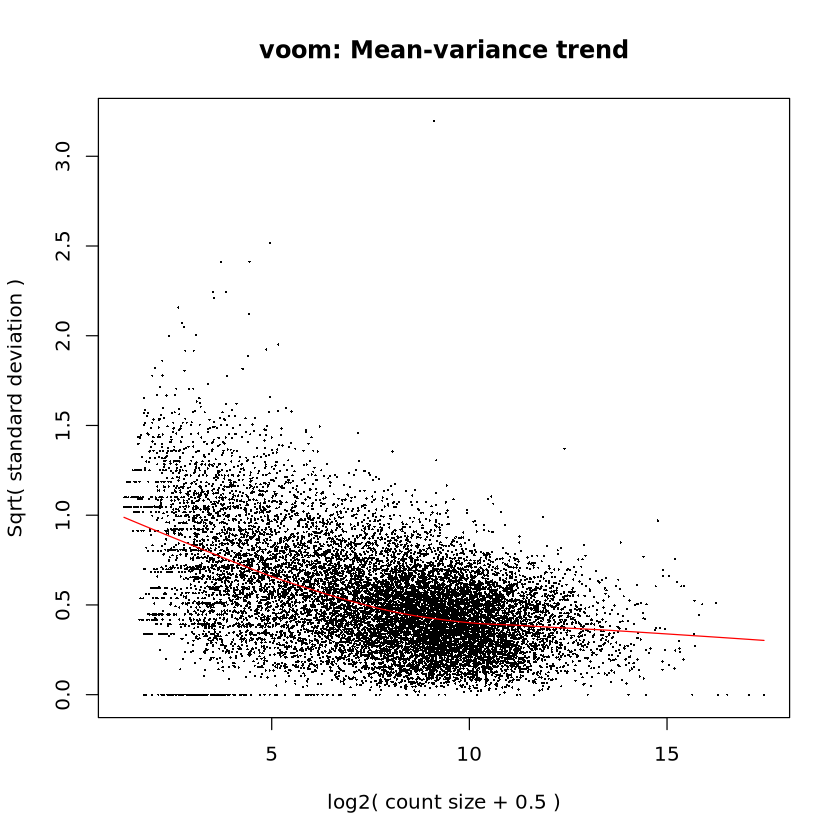

In [59]:
## DE分析  limma-trend（logCPM,有相似文库大小）  or  voom（文库大小差异大）
# de <- cpm(dge, log=TRUE, prior.count=3)  #如选择logCPM，则eBayes设trend=TRUE
de <- voom(dge,design,plot=TRUE, normalize="quantile")
fit1 <- lmFit(de, design)               #线性拟合
fit2 <- contrasts.fit(fit1,cont.matrix) #统计检验
efit <- eBayes(fit2, trend=F)  #Apply empirical Bayes smoothing to the standard errors

tempDEG <- topTable(efit, coef=paste0(exp,'-',ctr), n=Inf)  #padj值从小到大排列
DEG_limma_voom  <- na.omit(tempDEG)

In [60]:
write.csv(DEG_limma_voom, "DEG_limma_voom.csv")

## 4. 保存DEG数据


In [63]:
#### 保存DEG数据 ####
save(DEG_limma_voom,DEG_DEseq2,DEG_edgeR,
       file ='test_DEG_results.Rdata') 

#### 合并三种DEG文件交集至csv
allg <- intersect(rownames(DEG_limma_voom),rownames(DEG_edgeR))#取交集
allg <- intersect(allg,rownames(DEG_DEseq2))
head(allg)

[1] "Tpm1"    "Pim2"    "Peg10"   "Cnn2"    "Grb10"   "Gm28437"

In [64]:
ALL_DEG <- cbind(DEG_limma_voom[allg,c(1,4,5)],
                 DEG_edgeR[allg,c(1,4,5)],
                 DEG_DEseq2[allg,c(2,5,6)]) 
colnames(ALL_DEG)
colnames(ALL_DEG) <- c('limma_log2FC','limma_pvalue','limma_padj',
                        'edgeR_log2FC','edgeR_pvalue','edgeR_padj',
                        'DEseq2_log2FC','DEseq2_pvalue','DEseq2_padj')
write.csv(ALL_DEG,file = 'test_DEG_results.csv')

[1] "logFC"          "P.Value"        "adj.P.Val"      "logFC"         
[5] "PValue"         "FDR"            "log2FoldChange" "pvalue"        
[9] "padj"

## 二、3种差异分析结果比较

由于本次样品两组间差异十分显著，差异基因很多，因此筛选阈值调整为：`FoldChang=10，padj=0.001`。一般情况下选择`FoldChang=1.5~4，padj<=0.05`即可，根据样本情况而定。 下面查看三种差异分析结果的相关性和差异基因的重叠情况。

```R
#### 比较一下三种DEG方法结果 ####
load(list.files(pattern = 'DEG_results.Rdata'))
a <- read.csv(file = list.files(pattern = 'DEG_results.csv'),
              header = T,
              row.names = 1)

#查看相关性、一致性
colnames(a)
print(cor(a[,c(1,4,7)])) 

#查看显著差异基因重叠性，绘制韦恩图
#BiocManager::install("RBGL") #安装依赖包
#install.packages("Vennerable", repos="http://R-Forge.R-project.org") #安装Vennerable包
library(Vennerable) 

log2FC_cutoff=log2(10);  p_cutoff=0.001   #筛选显著差异基因比较
if(T){#根据Padj筛选
DEseq2_deg <- rownames(DEG_DEseq2[with(DEG_DEseq2,abs(log2FoldChange)>log2FC_cutoff & padj<p_cutoff),])
edgeR_deg <- rownames(DEG_edgeR[with(DEG_edgeR,abs(logFC)>log2FC_cutoff & FDR<p_cutoff),])
limma_deg <- rownames(DEG_limma_voom[with(DEG_limma_voom,abs(logFC)>log2FC_cutoff & adj.P.Val<p_cutoff),])
}

mylist <- list(DEseq2=DEseq2_deg, edgeR=edgeR_deg, limma=limma_deg)
str(mylist)
Vennplot <- Venn(mylist)
Vennplot1 <- Vennplot[,c('DEseq2','edgeR')]
Vennplot2 <- Vennplot[,c('DEseq2','limma')]
Vennplot3 <- Vennplot[,c('limma','edgeR')]

pdf(file = paste0('3DEG_Vennplot_lg2FC',log2FC_cutoff,'.pdf'))
plot(Vennplot, doWeights = F)
plot(Vennplot, doWeights = T) #doWeights=T设置为按数量比例绘图
plot(Vennplot1, doWeights = T)
plot(Vennplot2, doWeights = T)
plot(Vennplot3, doWeights = T)
# dev.off()
```


In [65]:
#### 比较一下三种DEG方法结果 ####
load(list.files(pattern = 'DEG_results.Rdata'))
list.files(pattern = 'DEG_results.csv')
a <- read.csv(file = list.files(pattern = 'DEG_results.csv'),
              header = T,
              row.names = 1)

head(a)

[1] "test_DEG_results.csv"

,limma_log2FC,limma_pvalue,limma_padj,edgeR_log2FC,edgeR_pvalue,edgeR_padj,DEseq2_log2FC,DEseq2_pvalue,DEseq2_padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tpm1,4.946443,6.347314e-06,0.01508032,4.849864,5.378621e-09,2.742934e-06,4.880980,6.676383e-61,3.711299e-58
Pim2,6.328607,4.870439e-06,0.01508032,6.229345,1.099565e-09,2.017942e-06,6.261063,4.250990e-92,1.023993e-88
Peg10,6.905772,8.850248e-06,0.01508032,6.764739,2.661146e-09,2.742934e-06,6.796205,2.314311e-91,4.778392e-88
Cnn2,4.735250,1.345062e-05,0.01508032,4.747496,9.356466e-09,2.904057e-06,4.778866,8.216343e-53,3.298633e-50
Grb10,5.326215,1.424813e-05,0.01508032,5.252398,6.411420e-09,2.747673e-06,5.283679,1.380200e-62,8.673058e-60
Gm28437,6.128020,1.481064e-05,0.01508032,6.155817,5.417522e-09,2.742934e-06,6.186847,3.150111e-78,3.035237e-75


In [66]:
#查看相关性、一致性
colnames(a)
print(cor(a[,c(1,4,7)])) 

[1] "limma_log2FC"  "limma_pvalue"  "limma_padj"    "edgeR_log2FC" 
[5] "edgeR_pvalue"  "edgeR_padj"    "DEseq2_log2FC" "DEseq2_pvalue"
[9] "DEseq2_padj"

              limma_log2FC edgeR_log2FC DEseq2_log2FC
limma_log2FC     1.0000000    0.9604493     0.9706300
edgeR_log2FC     0.9604493    1.0000000     0.9984325
DEseq2_log2FC    0.9706300    0.9984325     1.0000000


In [89]:
DEG_limma_voom

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tpm1,4.946443,7.595238,27.50056,6.347314e-06,0.01508032,4.881370
Pim2,6.328607,6.140621,29.28884,4.870439e-06,0.01508032,4.851553
Peg10,6.905772,5.938592,25.40842,8.850248e-06,0.01508032,4.396838
Cnn2,4.735250,6.267418,22.99659,1.345062e-05,0.01508032,4.173143
Grb10,5.326215,6.723045,22.68291,1.424813e-05,0.01508032,4.165840
Gm28437,6.128020,7.107691,22.47442,1.481064e-05,0.01508032,4.162270
Glipr2,4.691459,6.419948,22.73357,1.411546e-05,0.01508032,4.148621
Lin28a,4.176914,7.584894,21.59372,1.751253e-05,0.01508032,4.031961
Vim,3.268232,9.558458,20.29577,2.270450e-05,0.01508032,3.823638


In [99]:
#查看显著差异基因重叠性，绘制韦恩图
#BiocManager::install("RBGL") #安装依赖包
#install.packages("Vennerable", repos="http://R-Forge.R-project.org") #安装Vennerable包
library(Vennerable) 

log2FC_cutoff=log2(10);  
p_cutoff=0.1   #筛选显著差异基因比较
if(T){#根据Padj筛选
DEseq2_deg <- rownames(DEG_DEseq2[with(DEG_DEseq2,abs(log2FoldChange)>log2FC_cutoff & padj<p_cutoff),])
edgeR_deg <- rownames(DEG_edgeR[with(DEG_edgeR,abs(logFC)>log2FC_cutoff & FDR<p_cutoff),])
limma_deg <- rownames(DEG_limma_voom[with(DEG_limma_voom,abs(logFC)>log2FC_cutoff & adj.P.Val<p_cutoff),])
}

In [100]:
limma_deg

[1] "Tpm1"          "Pim2"          "Peg10"         "Cnn2"         
   [5] "Grb10"         "Gm28437"       "Glipr2"        "Lin28a"       
   [9] "Zyx"           "Prdx6"         "Igfbp5"        "Axl"          
  [13] "Pea15a"        "Dbn1"          "Tgfbi"         "Marcks"       
  [17] "S100a6"        "Sox4"          "Prtg"          "Parva"        
  [21] "Cdkn1c"        "Gsn"           "Ahcy"          "Ass1"         
  [25] "Gm8113"        "Flnc"          "Mmd"           "Arl4c"        
  [29] "Ccn2"          "Phldb1"        "Dpysl3"        "Prickle1"     
  [33] "Fzd2"          "Clip3"         "Rpl15-ps6"     "Lgals1"       
  [37] "Anxa5"         "Nrep"          "Serpine1"      "Alpl"         
  [41] "Fkbp10"        "Nanog"         "Col1a1"        "Lef1"         
  [45] "Ak4"           "Arrb1"         "Tspan9"        "Kit"          
  [49] "Ttyh3"         "Pdlim7"        "Rtl8b"         "Fgf4"         
  [53] "Serpinh1"      "Upp1"          "Aif1l"         "Tpm2"         
  [57] "Lbh"           "Igfbp3"        "Krt8"          "Dtx4"         
  [61] "Rps7-ps3"      "Rps4l"         "Gja1"          "Jam2"         
  [65] "Sox11"         "Basp1"         "Tdh"           "Dusp6"        
  [69] "Anxa2"         "Sall2"         "Hmga2"         "Krt18"        
  [73] "Dysf"          "Itga3"         "Tpt1-ps3"      "Selenon"      
  [77] "Spred3"        "Loxl2"         "Anxa1"         "Wnt7b"        
  [81] "Cryab"         "Nnat"          "T"             "Col4a1"       
  [85] "Ccnd2"         "Itga7"         "Rhobtb3"       "Sema6a"       
  [89] "Pcdh1"         "Car2"          "Agpat4"        "Crmp1"        
  [93] "Klf2"          "Mmp9"          "Gm10282"       "Mxra8"        
  [97] "Itgb3"         "Gjb3"          "Klf4"          "Col5a2"       
 [101] "Angptl2"       "Inf2"          "Rassf3"        "Emp3"         
 [105] "Nuak1"         "Fosl2"         "Slc39a14"      "Mogat2"       
 [109] "Lsr"           "Phlda1"        "Adcy6"         "Efnb2"        
 [113] "Bmp1"          "Efnb1"         "Tspan2"        "Pmaip1"       
 [117] "Ano10"         "Rab31"         "Serpinf1"      "Colec12"      
 [121] "Sfrp2"         "Trib2"         "Mest"          "Rpp25"        
 [125] "Dusp5"         "Mmp2"          "Sorbs3"        "Zfp703"       
 [129] "Ak3"           "Rps27"         "Gdpd5"         "Zfp629"       
 [133] "Pxdn"          "Cd248"         "Csf1"          "Bin1"         
 [137] "Satb1"         "Bag2"          "Igsf9"         "Col1a2"       
 [141] "Zfp334"        "Perp"          "Amot"          "Soat1"        
 [145] "Pou3f1"        "Apln"          "Snx33"         "Mmp14"        
 [149] "Col2a1"        "App"           "Col7a1"        "Aldh1l1"      
 [153] "Lmo4"          "Cntfr"         "Rdh10"         "Plekho1"      
 [157] "Gm12191"       "Mtarc2"        "Kif1a"         "Dlg4"         
 [161] "Mpdz"          "Plxnb1"        "Myc"           "Lrrfip1"      
 [165] "Tpm3-rs7"      "Ccn4"          "Sox1"          "Celsr2"       
 [169] "Inpp5d"        "Grik5"         "Mapk12"        "Castor2"      
 [173] "Sort1"         "Rtl8a"         "Pbx3"          "Tspan7"       
 [177] "Endod1"        "Elf3"          "Atxn1l"        "Limd2"        
 [181] "Hist1h2ap"     "Epha1"         "Clcn5"         "Ltbp1"        
 [185] "Esrrb"         "Dmtn"          "Fbn1"          "Mxd4"         
 [189] "Gm10359"       "Sema4c"        "Meis3"         "Antxr1"       
 [193] "Des"           "Dap"           "Lats2"         "Vash2"        
 [197] "A4galt"        "Lrrc8b"        "Tagln"         "Mical2"       
 [201] "Osbpl5"        "Plat"          "Arhgef26"      "Irs2"         
 [205] "Cgnl1"         "Zfp296"        "Penk"          "Ets1"         
 [209] "Kpna2"         "Bcl3"          "Thbs3"         "Tgfb2"        
 [213] "Lrp2"          "Tshz1"         "Cdh2"          "Greb1"        
 [217] "Cdc42ep1"      "Tmx4"          "Gpsm1"         "Dusp18"       
 [221] "Slc1a3"        "Reep2"         "Rin1"          "Greb1l"       
 [225] "Lin28b"        "Slc

In [101]:
mylist <- list(DEseq2=DEseq2_deg, 
               edgeR=edgeR_deg, 
               limma=limma_deg)



List of 3
 $ DEseq2: chr [1:1843] "Flnc" "Col1a1" "Tdh" "Ccnd2" ...
 $ edgeR : chr [1:2107] "Thbs1" "Flnc" "Ccnd2" "Col1a2" ...
 $ limma : chr [1:1814] "Tpm1" "Pim2" "Peg10" "Cnn2" ...


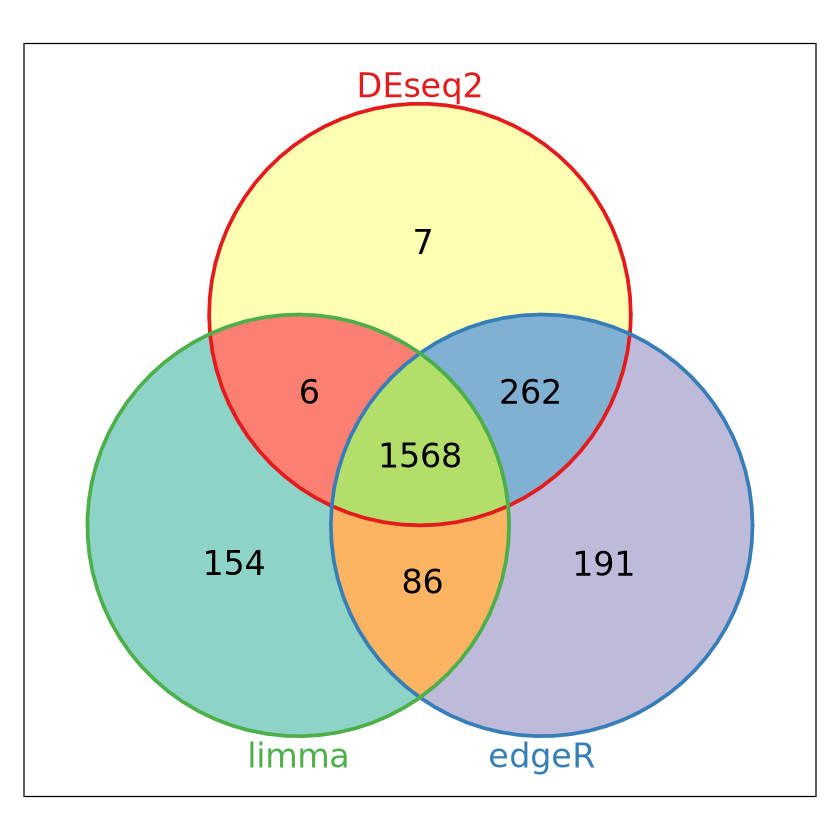

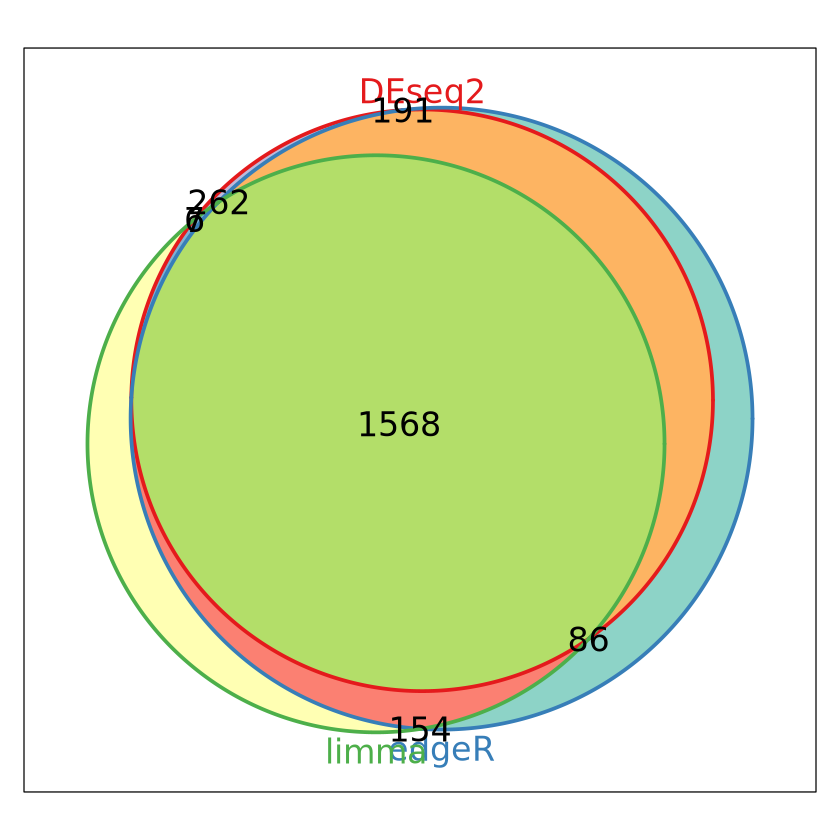

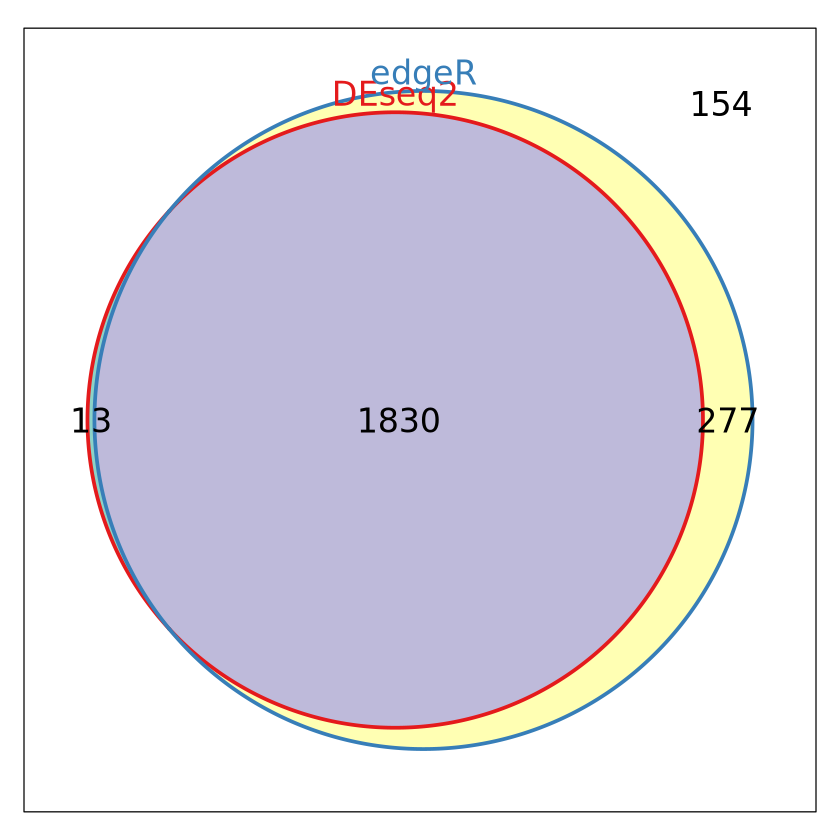

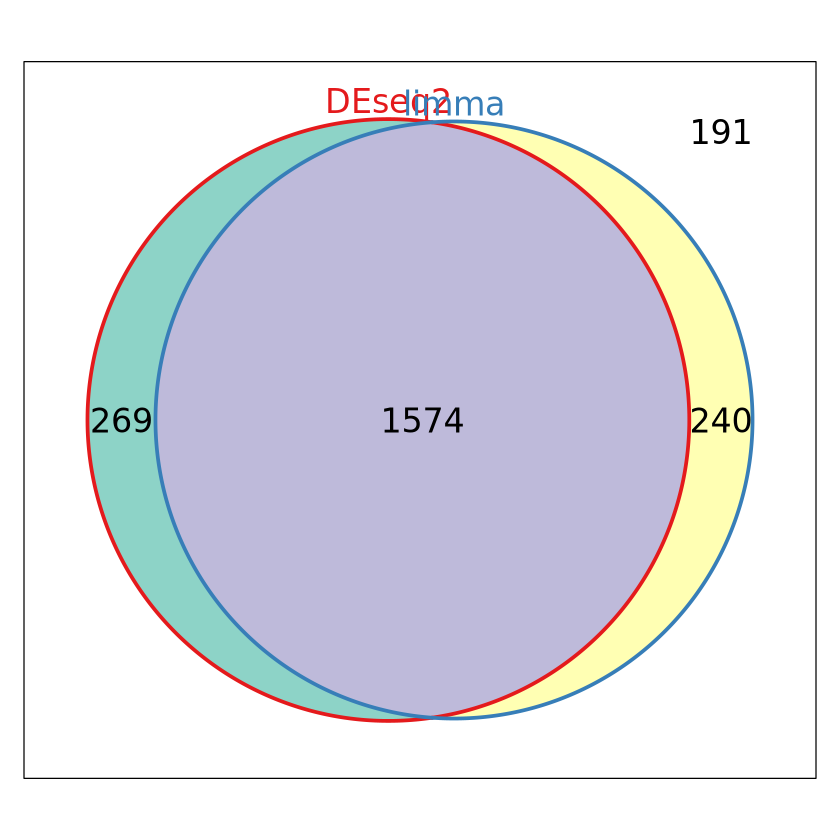

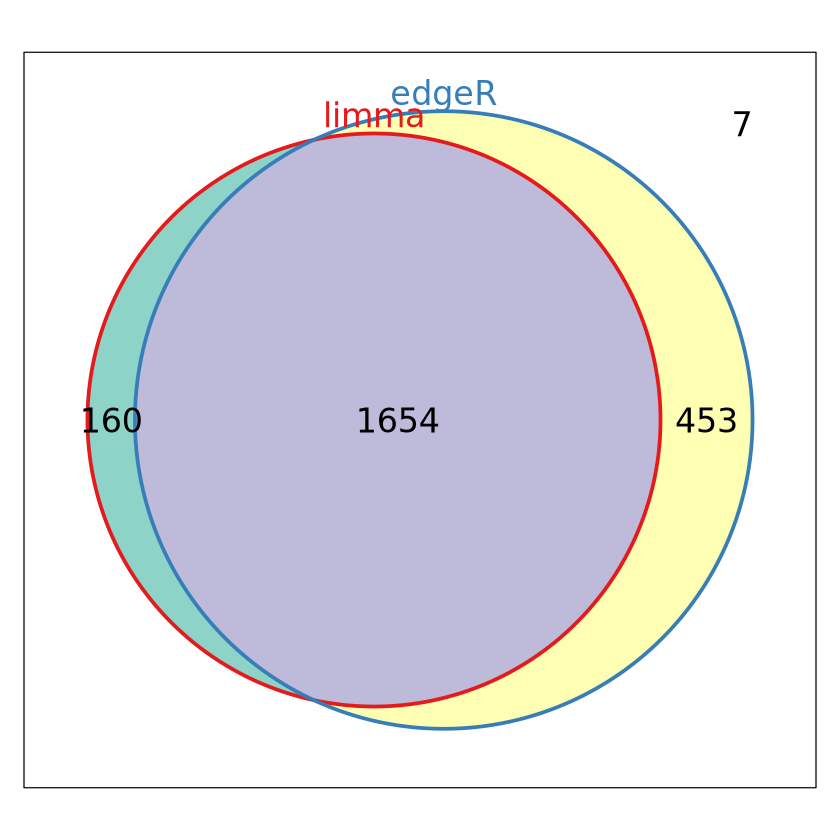

In [103]:

str(mylist)
Vennplot <- Venn(mylist)
Vennplot1 <- Vennplot[,c('DEseq2','edgeR')]
Vennplot2 <- Vennplot[,c('DEseq2','limma')]
Vennplot3 <- Vennplot[,c('limma','edgeR')]

# pdf(file = paste0('3DEG_Vennplot_lg2FC',log2FC_cutoff,'.pdf'))
plot(Vennplot, doWeights = F)
plot(Vennplot, doWeights = T) #doWeights=T设置为按数量比例绘图
plot(Vennplot1, doWeights = T)
plot(Vennplot2, doWeights = T)
plot(Vennplot3, doWeights = T)
# dev.off()

## 三、选取差异基因绘制火山图和热图
以下示范选取`DESeq2`差异分析结果进行绘制, 筛选阈值设置为：`FoldChang=10，padj=0.001`
### 1. 火山图的绘制

```R
library(ggplot2)
library(pheatmap)
##筛选条件设置
log2FC_cutoff = log2(10)
padj_cutoff = 0.001
##选取差异分析结果
need_DEG <- DEG_DEseq2[,c(2,6)] #选取log2FoldChange, padj信息
colnames(need_DEG) <- c('log2FoldChange','padj') 

need_DEG$significance  <- as.factor(ifelse(need_DEG$padj < padj_cutoff & abs(need_DEG$log2FoldChange) > log2FC_cutoff,
                                           ifelse(need_DEG$log2FoldChange > log2FC_cutoff ,'UP','DOWN'),'NOT'))

title <- paste0(' Up :  ',nrow(need_DEG[need_DEG$significance =='UP',]) ,
                     '\n Down : ',nrow(need_DEG[need_DEG$significance =='DOWN',]),
                     '\n FoldChange >= ',round(2^log2FC_cutoff,3))

g <- ggplot(data=need_DEG, 
            aes(x=log2FoldChange, y=-log10(padj), 
                color=significance)) +
  #点和背景
  geom_point(alpha=0.4, size=1) +
  theme_classic()+ #无网格线
  #坐标轴
  xlab("log2 ( FoldChange )") + 
  ylab("-log10 ( P.adjust )") +
  #标题文本
  ggtitle( title ) +
  #分区颜色                  
  scale_colour_manual(values = c('blue','grey','red'))+ 
  #辅助线
  geom_vline(xintercept = c(-log2FC_cutoff,log2FC_cutoff),lty=4,col="grey",lwd=0.8) +
  geom_hline(yintercept = -log10(padj_cutoff),lty=4,col="grey",lwd=0.8) +
  #图例标题间距等设置
  theme(plot.title = element_text(hjust = 0.5), 
        plot.margin=unit(c(2,2,2,2),'lines'), #上右下左
        legend.title = element_blank(), #不显示图例标题
        legend.position="right")  #图例位置

ggsave(g,filename = 'volcano_padj.pdf',width =8,height =7.5)
```


In [104]:
library(ggplot2)
library(pheatmap)
##筛选条件设置
log2FC_cutoff = log2(10)
padj_cutoff = 0.001
##选取差异分析结果
need_DEG <- DEG_DEseq2[,c(2,6)] #选取log2FoldChange, padj信息
colnames(need_DEG) <- c('log2FoldChange','padj') 

need_DEG$significance  <- as.factor(ifelse(need_DEG$padj < padj_cutoff & abs(need_DEG$log2FoldChange) > log2FC_cutoff,
                                           ifelse(need_DEG$log2FoldChange > log2FC_cutoff ,'UP','DOWN'),'NOT'))

title <- paste0(' Up :  ',nrow(need_DEG[need_DEG$significance =='UP',]) ,
                     '\n Down : ',nrow(need_DEG[need_DEG$significance =='DOWN',]),
                     '\n FoldChange >= ',round(2^log2FC_cutoff,3))

g <- ggplot(data=need_DEG, 
            aes(x=log2FoldChange, 
                y=-log10(padj), 
                color=significance)) +
  #点和背景
  geom_point(alpha=0.4, size=1) +
  theme_classic()+ #无网格线
  #坐标轴
  xlab("log2 ( FoldChange )") + 
  ylab("-log10 ( P.adjust )") +
  #标题文本
  ggtitle( title ) +
  #分区颜色                  
  scale_colour_manual(values = c('blue','grey','red'))+ 
  #辅助线
  geom_vline(xintercept = c(-log2FC_cutoff,log2FC_cutoff),lty=4,col="grey",lwd=0.8) +
  geom_hline(yintercept = -log10(padj_cutoff),lty=4,col="grey",lwd=0.8) +
  #图例标题间距等设置
  theme(plot.title = element_text(hjust = 0.5), 
        plot.margin=unit(c(2,2,2,2),'lines'), #上右下左
        legend.title = element_blank(), #不显示图例标题
        legend.position="right")  #图例位置

ggsave(g,filename = 'volcano_padj.pdf',width =8,height =7.5)

### 2. 热图的绘制

```R
##选择要展示基因表达量的数据
# dat <- log2(edgeR::cpm(counts)+1) 
dat <- log2(tpm+1)
# dat <- read.table("../2.check/Deseq2_rld.txt"); colnames(dat) <- rownames(gl)  #R读取数据列名可能会出错，需要重新对应一下

gene_up <- rownames(need_DEG[with(need_DEG,log2FoldChange>log2FC_cutoff & padj<padj_cutoff),])
gene_down <- rownames(need_DEG[with(need_DEG,log2FoldChange< -log2FC_cutoff & padj<padj_cutoff),])
cg <- c(head(gene_up, 50),   #取前50 padj上下调基因名
        head(gene_down, 50))
cg <- na.omit(match(cg,rownames(dat))) 

pheatmap::pheatmap(dat[cg,],
                   show_colnames =T,
                   show_rownames = F,
                   #scale = "row",
                   fontsize = 7 ,
                   cluster_cols = T,
                   annotation_col=gl,
                   filename = 'heatmap_top50up&down_DEG.pdf')
```

In [114]:
##选择要展示基因表达量的数据
# dat <- log2(edgeR::cpm(counts)+1) 
dat <- log2(tpm+1)
# dat <- read.table("../2.check/Deseq2_rld.txt"); colnames(dat) <- rownames(gl)  #R读取数据列名可能会出错，需要重新对应一下

gene_up <- rownames(need_DEG[with(need_DEG,log2FoldChange>log2FC_cutoff & padj<padj_cutoff),])
gene_down <- rownames(need_DEG[with(need_DEG,log2FoldChange< -log2FC_cutoff & padj<padj_cutoff),])
cg <- c(head(gene_up, 50),   #取前50 padj上下调基因名
        head(gene_down, 50))
cg <- na.omit(match(cg,rownames(dat))) 

head(cg)

[1]  4620  2752  2093  2753 10335 10135

In [115]:
colnames(dat) <- c("RNA_mESCs_1","RNA_mESCs_2","RNA_EpiSCs_3")

In [116]:
head(dat[cg,])

,RNA_mESCs_1,RNA_mESCs_2,RNA_EpiSCs_3
,<dbl>,<dbl>,<dbl>
Flnc,0.2677767,0.2365551,6.470185
Col1a1,0.4090455,0.2362477,7.160135
Ccnd2,0.2056102,0.4463293,6.385243
Col1a2,0.1499123,0.2323464,6.629996
Pim2,3.7386585,3.5197876,9.602298
Peg10,2.0129630,1.5553676,7.862660


In [117]:
pheatmap::pheatmap(dat[cg,],
                   show_colnames =T,
                   show_rownames = F,
                   #scale = "row",
                   fontsize = 7 ,
                   cluster_cols = T,
                   annotation_col=gl,
                   filename = 'heatmap_top50up&down_DEG.pdf')

> 到此就完成了基因差异分析的基本过程，得到了不同分组间的差异基因相关信息，接下来就要对差异基因进行富集分析啦